# General Imporst

In [54]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import struct

import warnings
warnings.filterwarnings('ignore')
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.test.is_gpu_available()}")


TensorFlow Version: 2.18.0
GPU Available: True


I0000 00:00:1765321565.541003      47 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765321565.541226      47 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [55]:
print("Loading Arabic Dataset...")
X_train_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv", header=None)
Y_train_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv", header=None)
X_test_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTestImages 3360x1024.csv", header=None)
Y_test_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTestLabel 3360x1.csv", header=None)

print("Arabic Dataset Shapes:")
print(f"X_train_arabic: {X_train_arabic.shape}")
print(f"Y_train_arabic: {Y_train_arabic.shape}")
print(f"X_test_arabic: {X_test_arabic.shape}")
print(f"Y_test_arabic: {Y_test_arabic.shape}")


Loading Arabic Dataset...
Arabic Dataset Shapes:
X_train_arabic: (13440, 1024)
Y_train_arabic: (13440, 1)
X_test_arabic: (3360, 1024)
Y_test_arabic: (3360, 1)


In [56]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

print("\nLoading English Dataset...")
train_images_path = r"/kaggle/input/d/crawford/emnist/emnist_source_files/emnist-letters-train-images-idx3-ubyte"
train_labels_path = r"/kaggle/input/d/crawford/emnist/emnist_source_files/emnist-letters-train-labels-idx1-ubyte"
test_images_path = r"/kaggle/input/d/crawford/emnist/emnist_source_files/emnist-letters-test-images-idx3-ubyte"
test_labels_path = r"/kaggle/input/d/crawford/emnist/emnist_source_files/emnist-letters-test-labels-idx1-ubyte"

x_train_english = read_idx(train_images_path)
y_train_english = read_idx(train_labels_path)
x_test_english = read_idx(test_images_path)
y_test_english = read_idx(test_labels_path)

print("English Dataset Shapes:")
print(f"x_train_english: {x_train_english.shape}")
print(f"y_train_english: {y_train_english.shape}")
print(f"x_test_english: {x_test_english.shape}")
print(f"y_test_english: {y_test_english.shape}")



Loading English Dataset...
English Dataset Shapes:
x_train_english: (124800, 28, 28)
y_train_english: (124800,)
x_test_english: (20800, 28, 28)
y_test_english: (20800,)


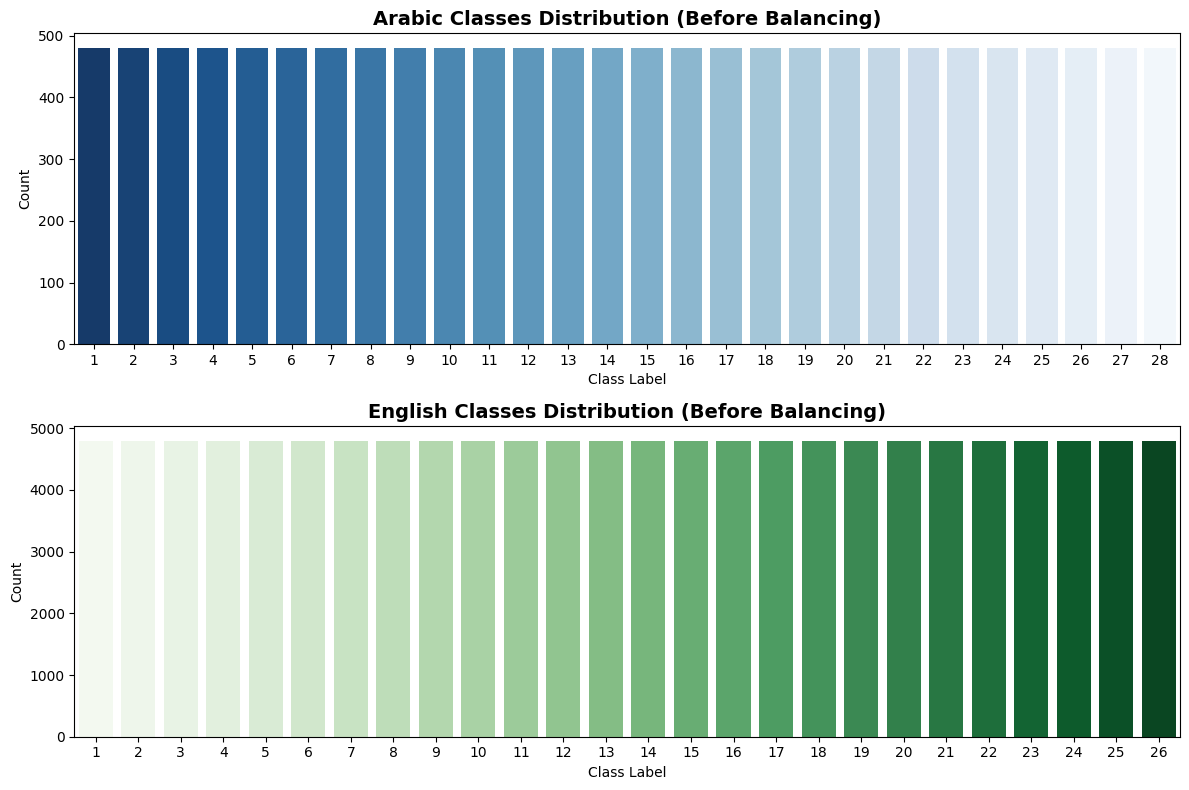

In [57]:
y_labels_arabic = Y_train_arabic.iloc[:, 0]
y_labels_english = y_train_english

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
axes[0].set_title("Arabic Classes Distribution (Before Balancing)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])
axes[1].set_title("English Classes Distribution (Before Balancing)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

Balancing English Dataset...

Balanced English Dataset:
x_train_english: (12480, 28, 28)
y_train_english: (12480,)
x_test_english: (3120, 28, 28)
y_test_english: (3120,)


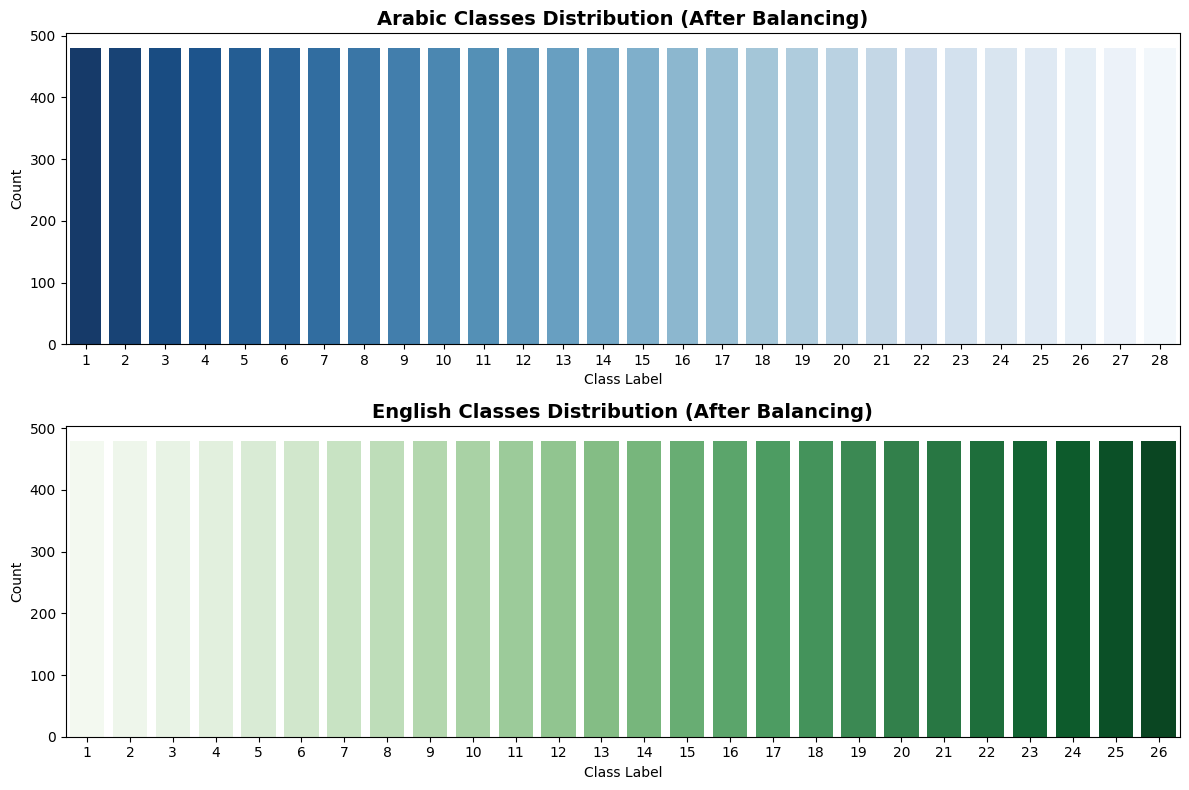

In [58]:
def balance_dataset(images, labels, samples_per_class, random_state=42):
    np.random.seed(random_state)
    unique_classes = np.unique(labels)
    balanced_images = []
    balanced_labels = []
    
    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]
        
        if len(class_indices) >= samples_per_class:
            selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
        else:
            selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=True)
        
        balanced_images.append(images[selected_indices])
        balanced_labels.append(labels[selected_indices])
    
    balanced_images = np.concatenate(balanced_images, axis=0)
    balanced_labels = np.concatenate(balanced_labels, axis=0)
    
    shuffle_indices = np.random.permutation(len(balanced_labels))
    return balanced_images[shuffle_indices], balanced_labels[shuffle_indices]

print("Balancing English Dataset...")
x_train_english, y_train_english = balance_dataset(x_train_english, y_train_english, 480, random_state=42)
x_test_english, y_test_english = balance_dataset(x_test_english, y_test_english, 120, random_state=42)

print(f"\nBalanced English Dataset:")
print(f"x_train_english: {x_train_english.shape}")
print(f"y_train_english: {y_train_english.shape}")
print(f"x_test_english: {x_test_english.shape}")
print(f"y_test_english: {y_test_english.shape}")

# Cell 6: Visualize Class Distribution (After Balancing)
y_labels_arabic = Y_train_arabic.iloc[:, 0]
y_labels_english = y_train_english

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
axes[0].set_title("Arabic Classes Distribution (After Balancing)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])
axes[1].set_title("English Classes Distribution (After Balancing)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

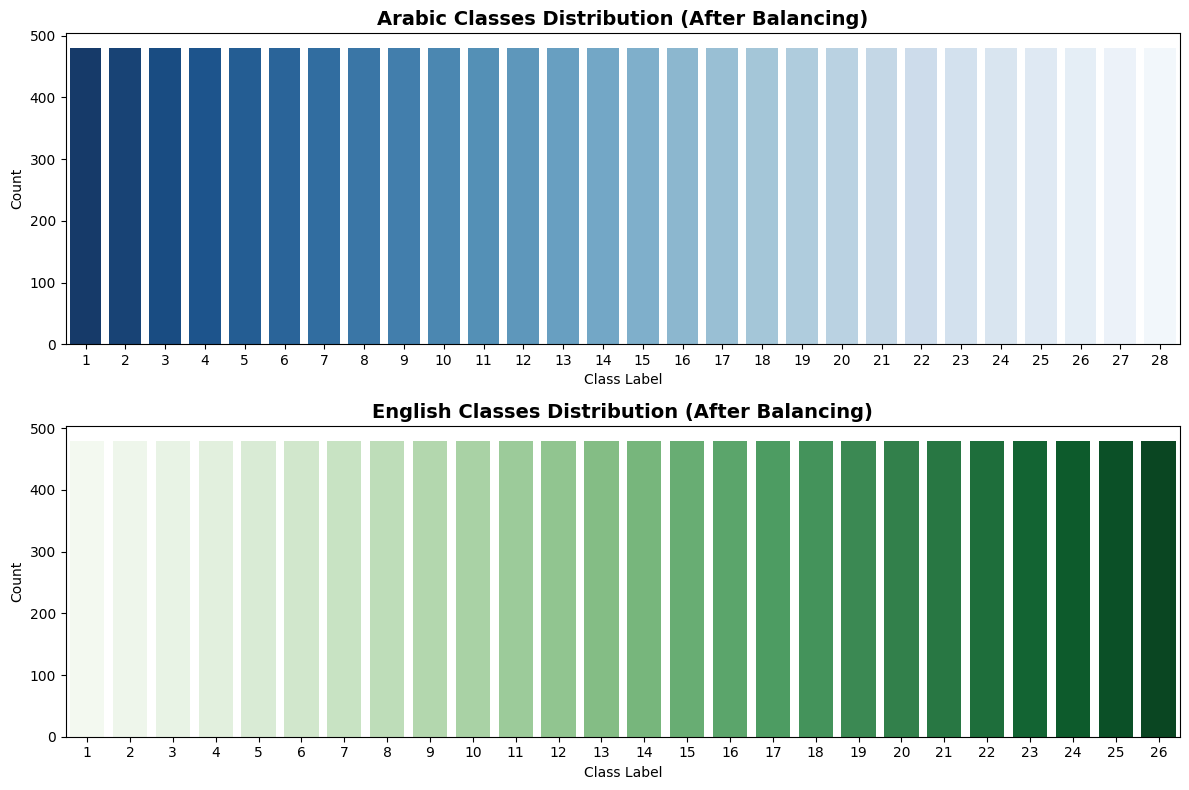

In [59]:
y_labels_arabic = Y_train_arabic.iloc[:, 0]
y_labels_english = y_train_english

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
axes[0].set_title("Arabic Classes Distribution (After Balancing)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])
axes[1].set_title("English Classes Distribution (After Balancing)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [60]:
def preprocess_images(X, original_size=(32, 32), target_size=(96, 96)):
    if not isinstance(X, np.ndarray):
        X = X.values
    
    # Reshape to (H, W, 1)
    X = X.reshape(-1, original_size[0], original_size[1], 1)
    
    # Resize to 96x96
    X = tf.image.resize(X, target_size).numpy()
    
    # Convert grayscale to RGB
    X = np.repeat(X, 3, axis=-1)
    
    # Vectorized rotation and flip (much faster!)
    X = np.rot90(X, k=-1, axes=(1, 2))  # Rotate all images at once
    X = np.flip(X, axis=2)  # Flip all images at once
    
    return X

print("Preprocessing images...")
X_train_arabic = preprocess_images(X_train_arabic, original_size=(32, 32), target_size=(96, 96))
X_test_arabic = preprocess_images(X_test_arabic, original_size=(32, 32), target_size=(96, 96))
x_train_english = preprocess_images(x_train_english, original_size=(28, 28), target_size=(96, 96))
x_test_english = preprocess_images(x_test_english, original_size=(28, 28), target_size=(96, 96))

Y_train_arabic = Y_train_arabic.values.flatten()
Y_test_arabic = Y_test_arabic.values.flatten()

print("\nPreprocessed Dataset Shapes:")
print(f"Arabic Train: {X_train_arabic.shape}, {Y_train_arabic.shape}")
print(f"Arabic Test: {X_test_arabic.shape}, {Y_test_arabic.shape}")
print(f"English Train: {x_train_english.shape}, {y_train_english.shape}")
print(f"English Test: {x_test_english.shape}, {y_test_english.shape}")


Preprocessing images...

Preprocessed Dataset Shapes:
Arabic Train: (13440, 96, 96, 3), (13440,)
Arabic Test: (3360, 96, 96, 3), (3360,)
English Train: (12480, 96, 96, 3), (12480,)
English Test: (3120, 96, 96, 3), (3120,)


In [61]:
class_mapping = {
    # Arabic (1-28)
    1: "أ", 2: "ب", 3: "ت", 4: "ث", 5: "ج", 6: "ح", 7: "خ", 8: "د", 9: "ذ", 10: "ر",
    11: "ز", 12: "س", 13: "ش", 14: "ص", 15: "ض", 16: "ط", 17: "ظ", 18: "ع", 19: "غ",
    20: "ف", 21: "ق", 22: "ك", 23: "ل", 24: "م", 25: "ن", 26: "هـ", 27: "و", 28: "ي",
    
    # English (29-54)
    29: "A", 30: "B", 31: "C", 32: "D", 33: "E", 34: "F", 35: "G", 36: "H", 37: "I", 38: "J",
    39: "K", 40: "L", 41: "M", 42: "N", 43: "O", 44: "P", 45: "Q", 46: "R", 47: "S", 48: "T",
    49: "U", 50: "V", 51: "W", 52: "X", 53: "Y", 54: "Z"
}

print(f"Total classes: {len(class_mapping)}")

Total classes: 54



Remapping English labels from 1-26 to 29-54...

Combined Dataset:
X_train: (25920, 96, 96, 3), Y_train: (25920,)
X_test: (6480, 96, 96, 3), Y_test: (6480,)
Label range: 1 to 54


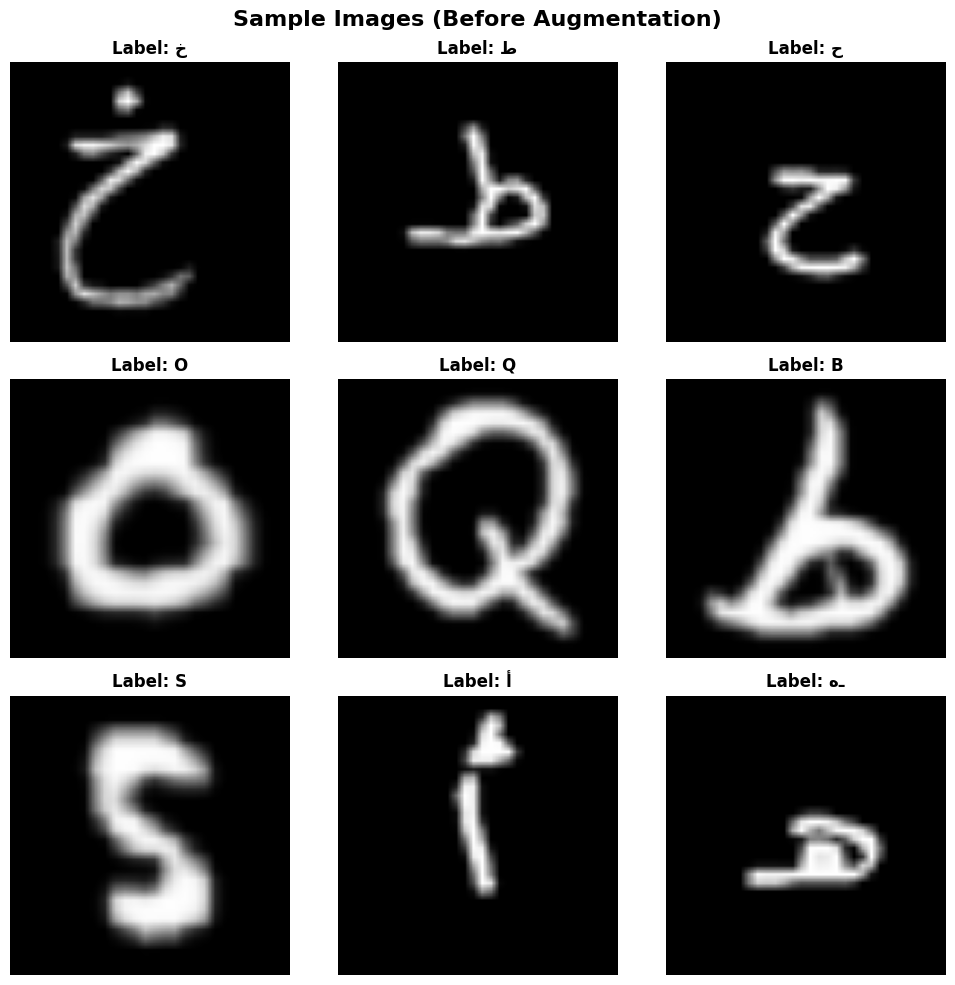

In [62]:
def visualize_samples(X, Y, class_mapping, title="Sample Images"):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    for ax in axes:
        idx = np.random.randint(0, len(X))
        img = X[idx].astype('uint8')
        label = class_mapping[Y[idx]]
        
        ax.imshow(img)
        ax.set_title(f"Label: {label}", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Remap English labels first
print("\nRemapping English labels from 1-26 to 29-54...")
y_train_english = y_train_english + 28
y_test_english = y_test_english + 28

# Combine datasets
X_train = np.concatenate([X_train_arabic, x_train_english], axis=0)
Y_train = np.concatenate([Y_train_arabic, y_train_english], axis=0)
X_test = np.concatenate([X_test_arabic, x_test_english], axis=0)
Y_test = np.concatenate([Y_test_arabic, y_test_english], axis=0)

print(f"\nCombined Dataset:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")
print(f"Label range: {Y_train.min()} to {Y_train.max()}")

visualize_samples(X_train, Y_train, class_mapping, "Sample Images (Before Augmentation)")


In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def add_noise(image):
    noise = np.random.normal(0, 10, image.shape)
    image = image + noise
    return np.clip(image, 0, 255)

print("Creating augmented training dataset...")

# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    # preprocessing_function=add_noise,
    fill_mode='nearest'
)

# Generate augmented samples (more efficient batching)
datagen.fit(X_train)
augmentation_factor = 1

# Use larger batch size for efficiency
batch_size = 128  # Increased from 32
augmented_images = []
augmented_labels = []

total_samples = len(X_train) * augmentation_factor
batches = 0
total_batches = total_samples // batch_size

print(f"Generating {total_samples:,} augmented samples...")

for X_batch, Y_batch in datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=False):
    augmented_images.append(X_batch)
    augmented_labels.append(Y_batch)
    batches += 1
    
    if batches % 50 == 0:  # Update less frequently
        print(f"Progress: {batches}/{total_batches} batches ({(batches/total_batches)*100:.1f}%)")
    
    if batches >= total_batches:
        break

# Efficient concatenation
print("Concatenating batches...")
X_train_augmented = np.vstack(augmented_images)
Y_train_augmented = np.concatenate(augmented_labels)

print(f"\nAugmented Training Data:")
print(f"X_train_augmented: {X_train_augmented.shape}")
print(f"Y_train_augmented: {Y_train_augmented.shape}")



Creating augmented training dataset...
Generating 25,920 augmented samples...
Progress: 50/202 batches (24.8%)
Progress: 100/202 batches (49.5%)
Progress: 150/202 batches (74.3%)
Progress: 200/202 batches (99.0%)
Concatenating batches...

Augmented Training Data:
X_train_augmented: (25856, 96, 96, 3)
Y_train_augmented: (25856,)


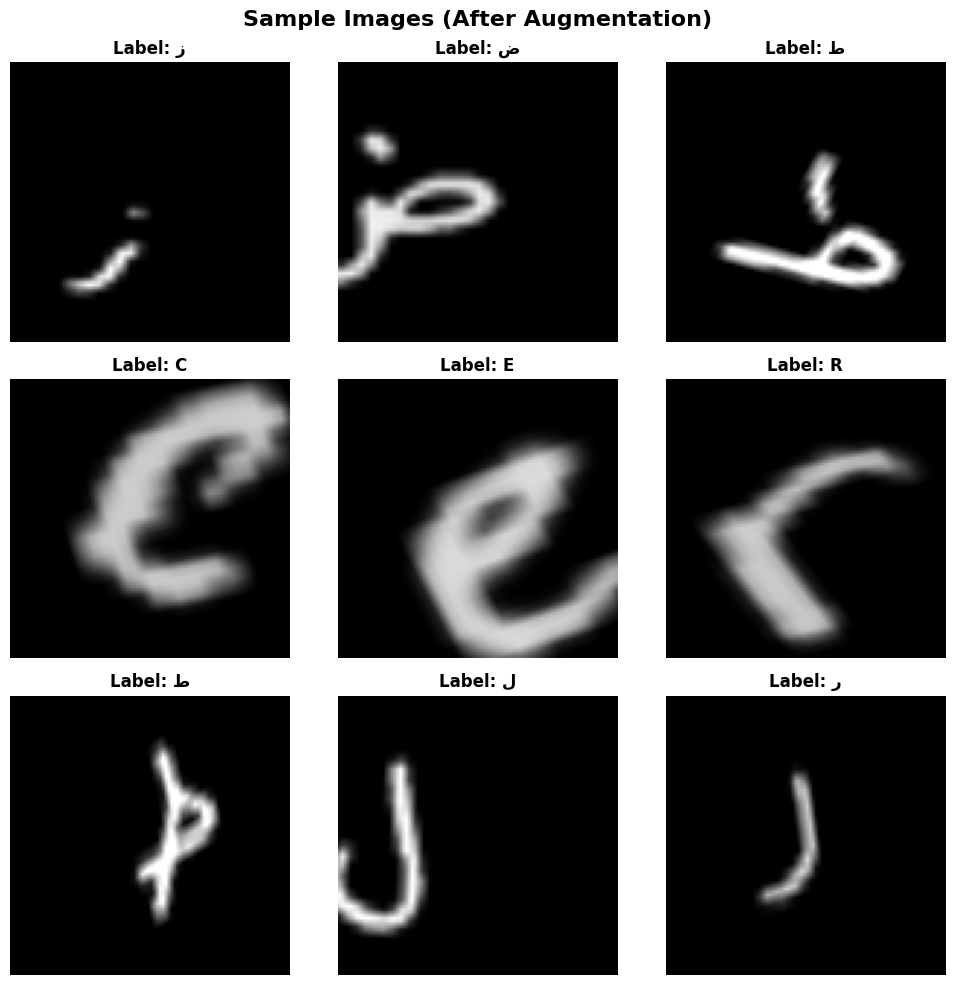

In [64]:
visualize_samples(X_train_augmented, Y_train_augmented, class_mapping, 
                 "Sample Images (After Augmentation)")

In [65]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

print("Preparing data for MobileNet...")

# Convert to 0-indexed labels
num_classes = 54
Y_train_sparse = Y_train_augmented.astype(int) - 1  # 1-54 to 0-53
Y_test_sparse = Y_test.astype(int) - 1

# Shuffle training data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
Y_train_sparse = Y_train_sparse[shuffle_idx]

# Preprocess for MobileNet
X_train_processed = preprocess_input(X_train_augmented.copy())
X_test_processed = preprocess_input(X_test.copy())

print(f"X_train_processed: {X_train_processed.shape}")
print(f"Y_train_sparse: {Y_train_sparse.shape}")
print(f"X_test_processed: {X_test_processed.shape}")
print(f"Y_test_sparse: {Y_test_sparse.shape}")
print(f"Label range: {Y_train_sparse.min()} to {Y_train_sparse.max()}")


Preparing data for MobileNet...
X_train_processed: (25856, 96, 96, 3)
Y_train_sparse: (25856,)
X_test_processed: (6480, 96, 96, 3)
Y_test_sparse: (6480,)
Label range: 0 to 53


In [66]:
from sklearn.model_selection import train_test_split

X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train_processed, 
    Y_train_sparse,
    test_size=0.15,
    random_state=42,
    stratify=Y_train_sparse
)

print(f"Training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_processed.shape}")


Training set: (21977, 96, 96, 3)
Validation set: (3879, 96, 96, 3)
Test set: (6480, 96, 96, 3)


In [67]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_mobilenet_model(input_shape=(96, 96, 3), num_classes=54):
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', name='dense_512')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', name='dense_256')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', name='Dense_layer')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

print("Building MobileNet model...")
model, base_model = build_mobilenet_model(num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

model.summary()


Building MobileNet model...

Total parameters: 3,124,854
Trainable parameters: 866,870


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 3,124,854 (11.92 MB)

 Trainable params: 866,870 (3.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

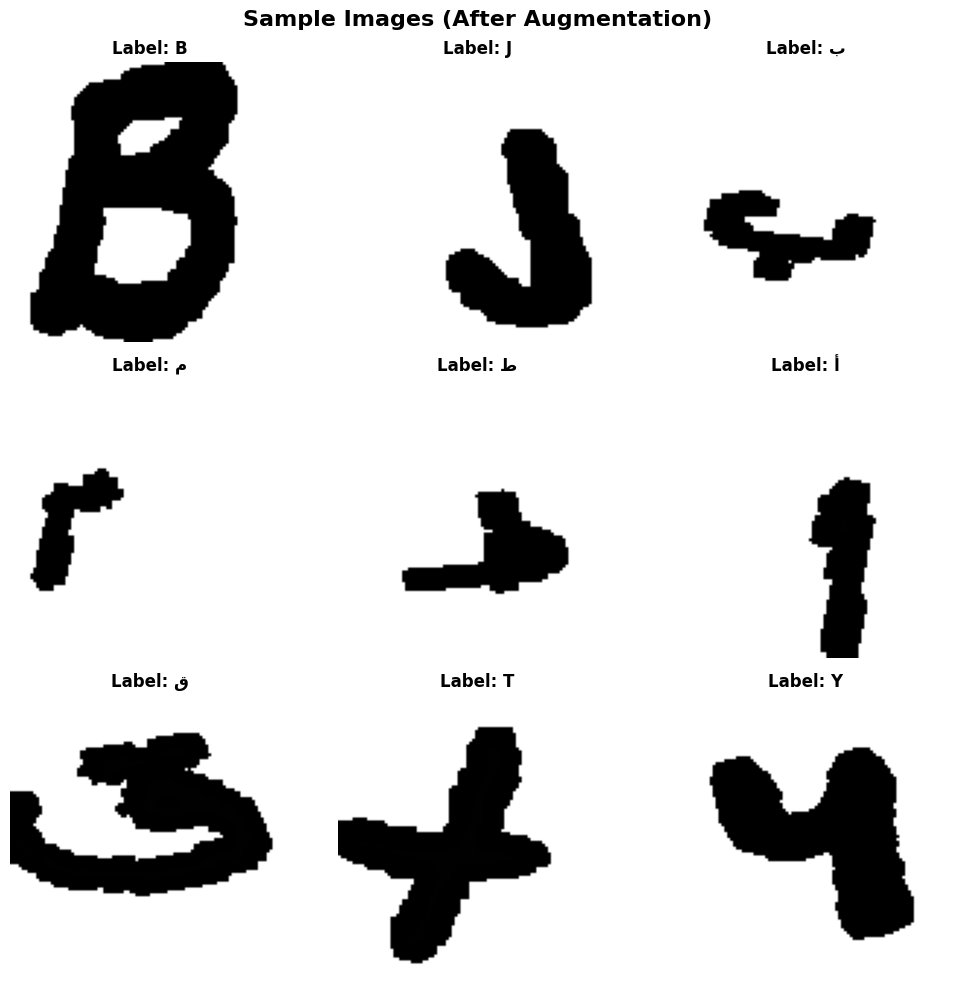

In [68]:
visualize_samples(X_train_final, Y_train_final + 1, class_mapping, 
                 "Sample Images (After Augmentation)")

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_mobilenet_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print("Starting training...")
history = model.fit(
    X_train_final,
    Y_train_final,
    batch_size=64,
    epochs=30,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Starting training...
Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1947 - loss: 3.0708
Epoch 1: val_accuracy improved from -inf to 0.60273, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.1951 - loss: 3.0688 - val_accuracy: 0.6027 - val_loss: 1.2487 - learning_rate: 0.0010
Epoch 2/30
340/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5269 - loss: 1.5135
Epoch 2: val_accuracy improved from 0.60273 to 0.66280, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5272 - loss: 1.5126 - val_accuracy: 0.6628 - val_loss: 1.0390 - learning_rate: 0.0010
Epoch 3/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6053 - loss: 1.2471
Epoch 3: val_accuracy improved from 0.66280 to 0.70766, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6054 - loss: 1.2468 - val_accuracy: 0.7077 - val_loss: 0.9306 - learning_rate: 0.0010
Epoch 4/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6529 - loss: 1.1103
Epoch 4: val_accuracy improved from 0.70766 to 0.71049, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6529 - loss: 1.1101 - val_accuracy: 0.7105 - val_loss: 0.8885 - learning_rate: 0.0010
Epoch 5/30
340/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6826 - loss: 1.0176
Epoch 5: val_accuracy improved from 0.71049 to 0.73009, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6826 - loss: 1.0173 - val_accuracy: 0.7301 - val_loss: 0.8471 - learning_rate: 0.0010
Epoch 6/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6991 - loss: 0.9394
Epoch 6: val_accuracy did not improve from 0.73009
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6991 - loss: 0.9395 - val_accuracy: 0.7247 - val_loss: 0.8617 - learning_rate: 0.0010
Epoch 7/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7198 - loss: 0.8749
Epoch 7: val_accuracy improved from 0.73009 to 0.73266, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7198 - loss: 0.8750 - val_accuracy: 0.7327 - val_loss: 0.8237 - learning_rate: 0.0010
Epoch 8/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7303 - loss: 0.8385
Epoch 8: val_accuracy improved from 0.73266 to 0.74246, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7304 - loss: 0.8383 - val_accuracy: 0.7425 - val_loss: 0.8223 - learning_rate: 0.0010
Epoch 9/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7426 - loss: 0.7833
Epoch 9: val_accuracy did not improve from 0.74246
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7426 - loss: 0.7834 - val_accuracy: 0.7363 - val_loss: 0.8362 - learning_rate: 0.0010
Epoch 10/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7586 - loss: 0.7412
Epoch 10: val_accuracy improved from 0.74246 to 0.74916, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7585 - loss: 0.7413 - val_accuracy: 0.7492 - val_loss: 0.7828 - learning_rate: 0.0010
Epoch 11/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7708 - loss: 0.6925
Epoch 11: val_accuracy did not improve from 0.74916
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7707 - loss: 0.6927 - val_accuracy: 0.7461 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 12/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7797 - loss: 0.6813
Epoch 12: val_accuracy improved from 0.74916 to 0.75354, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7797 - loss: 0.6813 - val_accuracy: 0.7535 - val_loss: 0.7967 - learning_rate: 0.0010
Epoch 13/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7906 - loss: 0.6529
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_accuracy did not improve from 0.75354
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7906 - loss: 0.6530 - val_accuracy: 0.7468 - val_loss: 0.8231 - learning_rate: 0.0010
Epoch 14/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8183 - loss: 0.5429
Epoch 14: val_accuracy improved from 0.75354 to 0.77829, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8183 - loss: 0.5427 - val_accuracy: 0.7783 - val_loss: 0.7581 - learning_rate: 5.0000e-04
Epoch 15/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8400 - loss: 0.4780
Epoch 15: val_accuracy did not improve from 0.77829
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8399 - loss: 0.4781 - val_accuracy: 0.7755 - val_loss: 0.7677 - learning_rate: 5.0000e-04
Epoch 16/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8460 - loss: 0.4495
Epoch 16: val_accuracy did not improve from 0.77829
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8460 - loss: 0.4496 - val_accuracy: 0.7695 - val_loss: 0.7703 - learning_rate: 5.0000e-04
Epoch 17/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8540 - loss: 0.4309
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_accuracy did not improve from 0.77829
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8539 - l

344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8673 - loss: 0.3919 - val_accuracy: 0.7863 - val_loss: 0.7561 - learning_rate: 2.5000e-04
Epoch 19/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8799 - loss: 0.3507
Epoch 19: val_accuracy improved from 0.78629 to 0.78757, saving model to best_mobilenet_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8799 - loss: 0.3507 - val_accuracy: 0.7876 - val_loss: 0.7542 - learning_rate: 2.5000e-04
Epoch 20/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8843 - loss: 0.3290
Epoch 20: val_accuracy did not improve from 0.78757
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8843 - loss: 0.3290 - val_accuracy: 0.7796 - val_loss: 0.7720 - learning_rate: 2.5000e-04
Epoch 21/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8887 - loss: 0.3232
Epoch 21: val_accuracy did not improve from 0.78757
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8887 - loss: 0.3232 - val_accuracy: 0.7871 - val_loss: 0.7787 - learning_rate: 2.5000e-04
Epoch 22/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8932 - loss: 0.3159
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 22: val_accuracy did not improve from 0.78757
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8932 - l

344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9110 - loss: 0.2621 - val_accuracy: 0.7902 - val_loss: 0.7975 - learning_rate: 1.2500e-04
Epoch 25/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9061 - loss: 0.2718
Epoch 25: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 25: val_accuracy did not improve from 0.79015
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9061 - loss: 0.2718 - val_accuracy: 0.7891 - val_loss: 0.8234 - learning_rate: 1.2500e-04
Epoch 26/30
341/344 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9129 - loss: 0.2475
Epoch 26: val_accuracy did not improve from 0.79015
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9129 - loss: 0.2476 - val_accuracy: 0.7894 - val_loss: 0.8128 - learning_rate: 6.2500e-05
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 19.

Training completed!


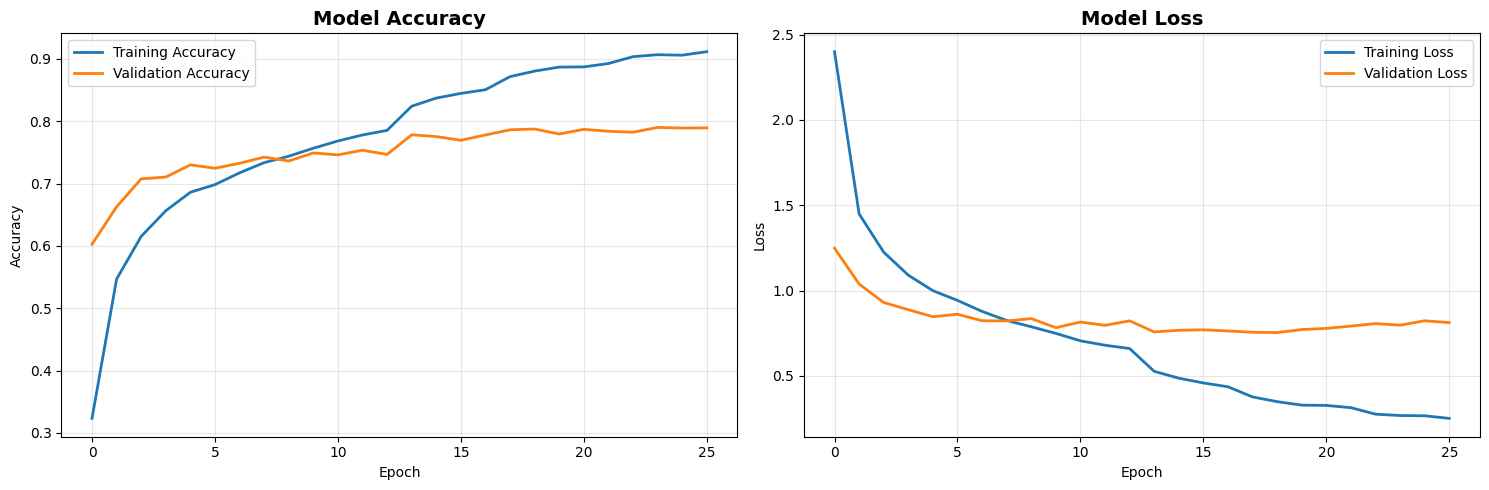

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



TEST SET EVALUATION RESULTS
Test Loss: 0.5551
Test Accuracy: 84.81%
Generating predictions on test set...


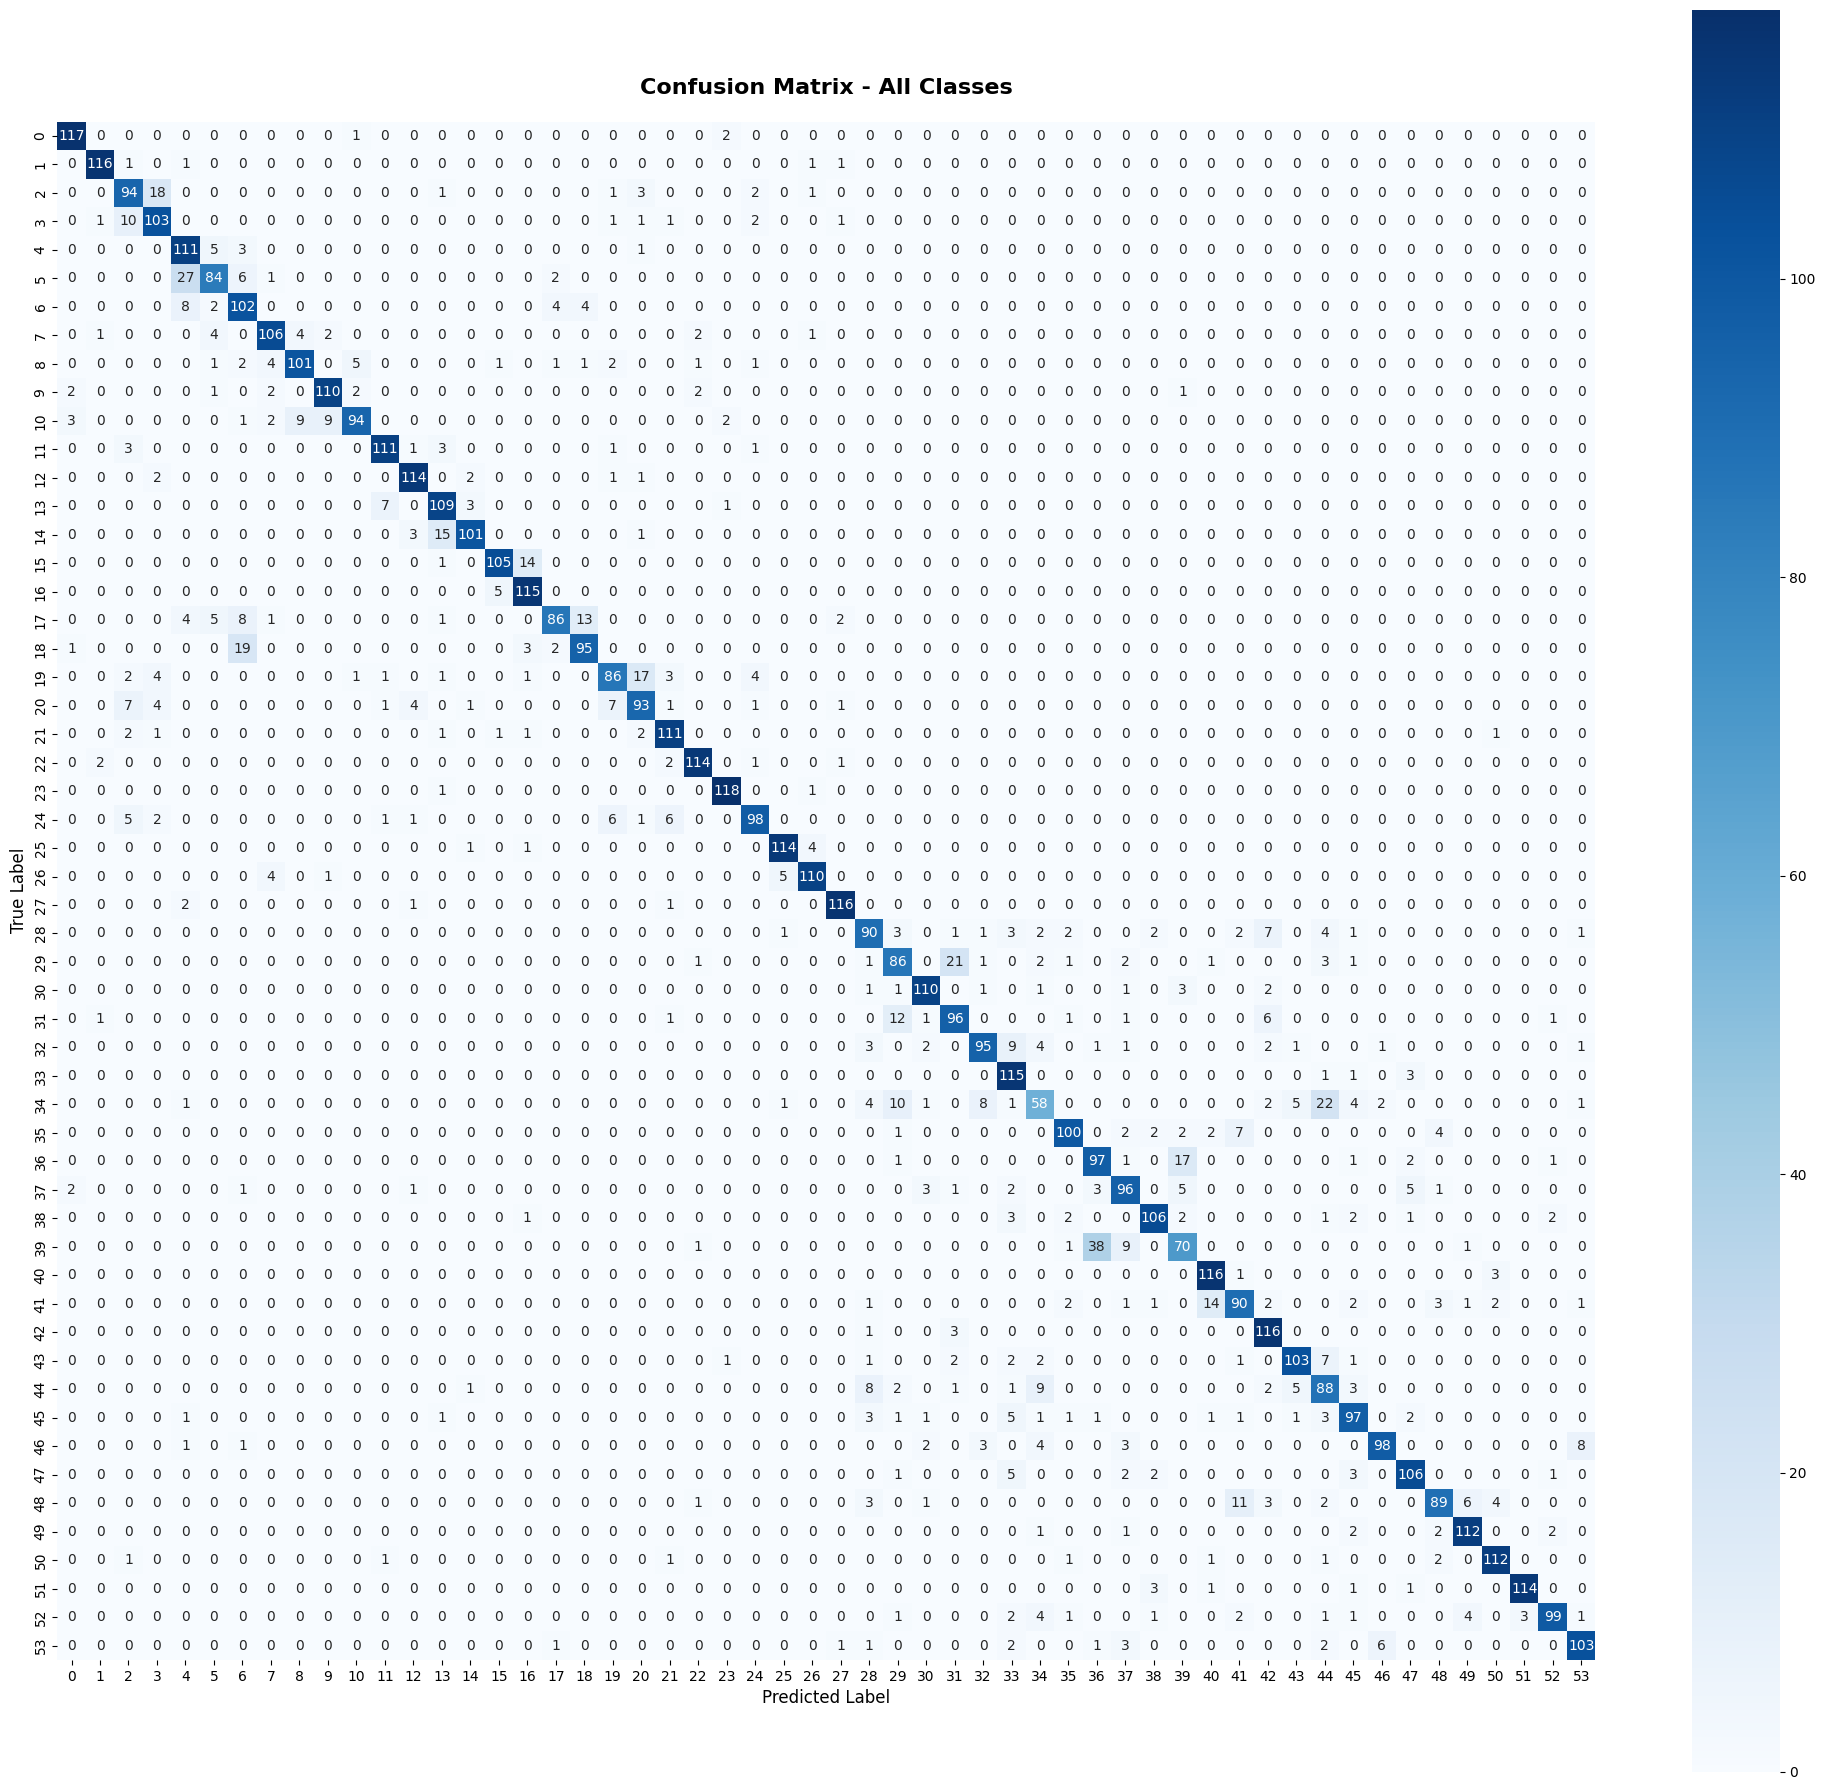

In [71]:
test_loss, test_accuracy = model.evaluate(X_test_processed, Y_test_sparse, verbose=0)

print(f"\n{'='*50}")
print(f"TEST SET EVALUATION RESULTS")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"{'='*50}")

# Cell 18: Generate Predictions and Confusion Matrix
print("Generating predictions on test set...")
Y_pred_probs = model.predict(X_test_processed, verbose=0)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(Y_test_sparse, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
plt.title('Confusion Matrix - All Classes', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [72]:
# Create readable class names
class_names = [class_mapping[i+1] for i in range(54)]

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(Y_test_sparse, Y_pred, target_names=class_names, digits=4))

# Cell 20: Per-Class Accuracy Analysis
print("\n" + "="*80)
print("PER-CLASS ACCURACY ANALYSIS")
print("="*80)

per_class_acc = []
for i in range(num_classes):
    mask = Y_test_sparse == i
    if np.sum(mask) > 0:
        acc = np.mean(Y_pred[mask] == i)
        per_class_acc.append((class_mapping[i+1], acc, np.sum(mask)))

per_class_acc.sort(key=lambda x: x[1])

print("\nTop 10 Best Performing Classes:")
print(f"{'Class':<10} {'Accuracy':<12} {'Samples':<10}")
print("-" * 35)
for char, acc, count in per_class_acc[-10:]:
    print(f"{char:<10} {acc*100:>6.2f}%      {count:<10}")

print("\nTop 10 Worst Performing Classes:")
print(f"{'Class':<10} {'Accuracy':<12} {'Samples':<10}")
print("-" * 35)
for char, acc, count in per_class_acc[:10]:
    print(f"{char:<10} {acc*100:>6.2f}%      {count:<10}")


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           أ     0.9360    0.9750    0.9551       120
           ب     0.9587    0.9667    0.9627       120
           ت     0.7520    0.7833    0.7673       120
           ث     0.7687    0.8583    0.8110       120
           ج     0.7115    0.9250    0.8043       120
           ح     0.8235    0.7000    0.7568       120
           خ     0.7133    0.8500    0.7757       120
           د     0.8833    0.8833    0.8833       120
           ذ     0.8860    0.8417    0.8632       120
           ر     0.9016    0.9167    0.9091       120
           ز     0.9126    0.7833    0.8430       120
           س     0.9098    0.9250    0.9174       120
           ش     0.9120    0.9500    0.9306       120
           ص     0.8134    0.9083    0.8583       120
           ض     0.9266    0.8417    0.8821       120
           ط     0.9375    0.8750    0.9052       120
           ظ     0.8456    0.9583    0.8984       120
    

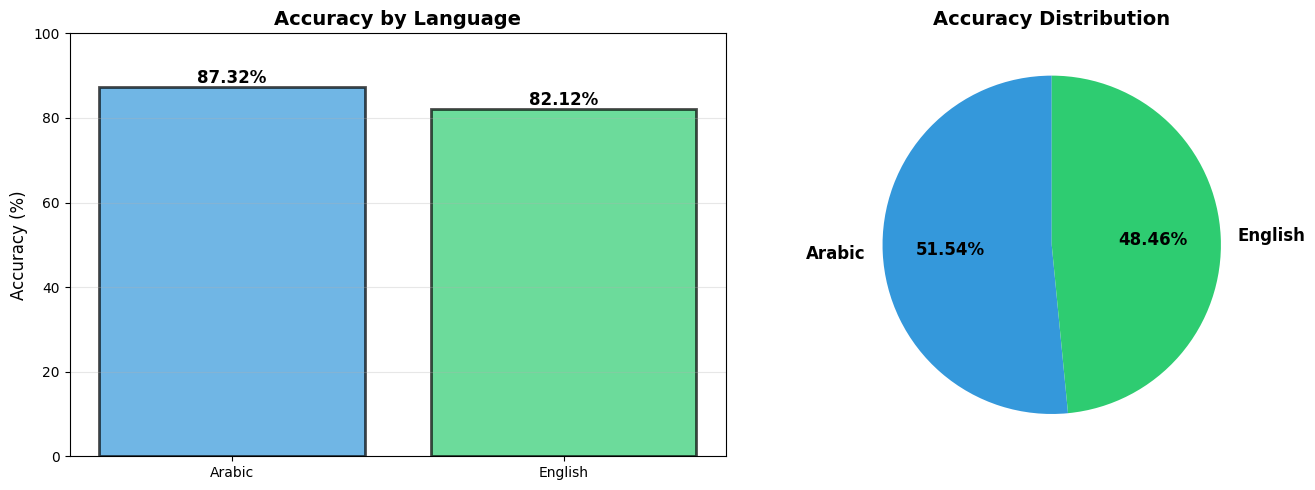


Arabic Characters Accuracy: 87.32%
English Characters Accuracy: 82.12%
Overall Test Accuracy: 84.81%


In [73]:
arabic_indices = Y_test_sparse < 28  # Classes 0-27 (Arabic)
english_indices = Y_test_sparse >= 28  # Classes 28-53 (English)

arabic_acc = np.mean(Y_pred[arabic_indices] == Y_test_sparse[arabic_indices])
english_acc = np.mean(Y_pred[english_indices] == Y_test_sparse[english_indices])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
languages = ['Arabic', 'English']
accuracies = [arabic_acc * 100, english_acc * 100]
colors = ['#3498db', '#2ecc71']

bars = ax1.bar(languages, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy by Language', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Pie chart
ax2.pie(accuracies, labels=languages, autopct='%1.2f%%', startangle=90,
        colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nArabic Characters Accuracy: {arabic_acc*100:.2f}%")
print(f"English Characters Accuracy: {english_acc*100:.2f}%")
print(f"Overall Test Accuracy: {test_accuracy*100:.2f}%")


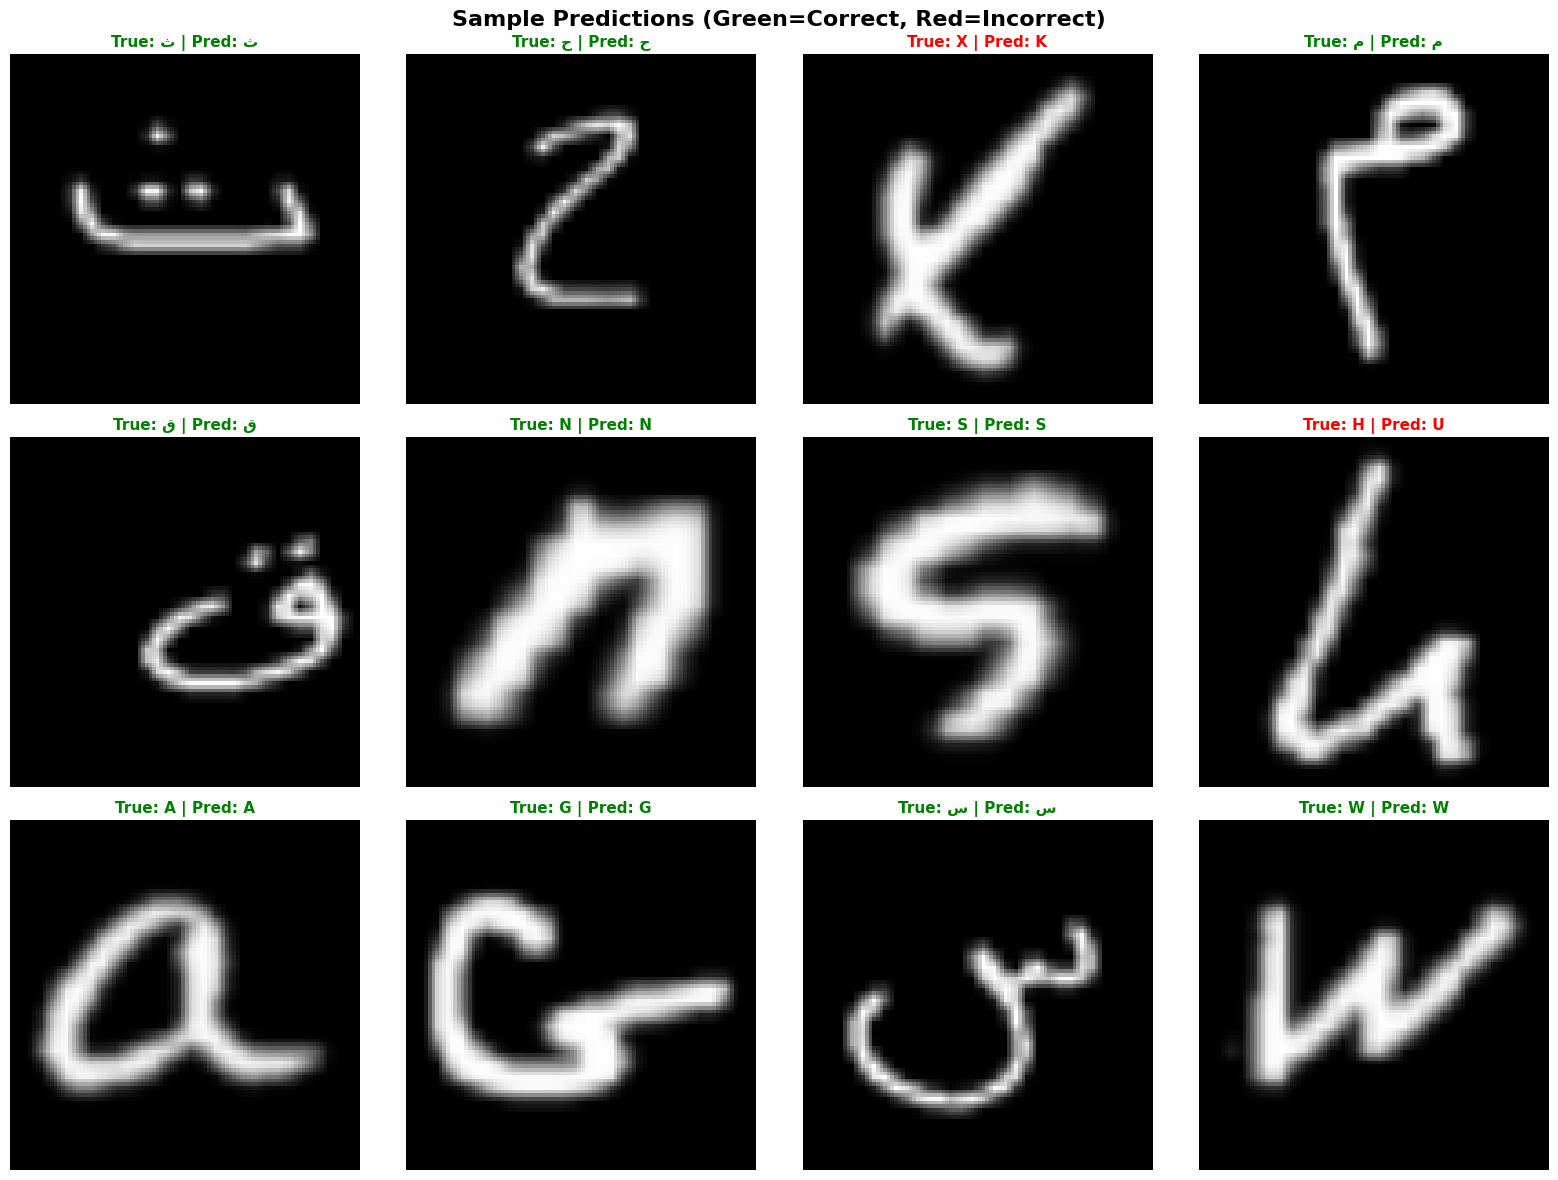

In [74]:
def visualize_predictions(X_processed, X_original, Y_true, Y_pred, class_mapping, num_samples=12):

    num_rows = 3
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
    axes = axes.flatten()
    
    indices = np.random.choice(len(X_processed), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Use ORIGINAL image for display (not preprocessed)
        img = X_original[idx].astype('uint8')
        
        true_label = class_mapping[Y_true[idx] + 1]
        pred_label = class_mapping[Y_pred[idx] + 1]
        
        color = 'green' if Y_true[idx] == Y_pred[idx] else 'red'
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label} | Pred: {pred_label}',
                         color=color, fontsize=11, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Use ORIGINAL test images for visualization (before MobileNet preprocessing)
visualize_predictions(X_test_processed, X_test, Y_test_sparse, Y_pred, class_mapping)
